
# E-Commerce Shipping Data

This dataset is provided by an *international e-commerce company selling electronic produts*.

My notebook will focus on **exploratory data analysis (EDA)** and comparing different state-of-art **machine learning models**.

The aim will be to predict of an order has been **delayed** or not based on other features, provide EDA insights and compare the state of ML models like Logistic Regression, Decision Trees, SVMs, Random Forest and k-Nearest Neighbour.

# Getting Started

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pal = sns.color_palette()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, recall_score

In [2]:
# Load the data
data = pd.read_csv('Train.csv')
data

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


# First Sightings

In [3]:
# Drop ID
data = data.drop('ID', axis=1)

In [4]:
# Print some information about the data
print("Missing values:", data.isna().sum().sum())
print("Categorical features:", len(data.select_dtypes('object').columns))
print("Numerical features:", len(data.select_dtypes('number').columns))

Missing values: 0
Categorical features: 4
Numerical features: 7


# Correlation of Numerical Features

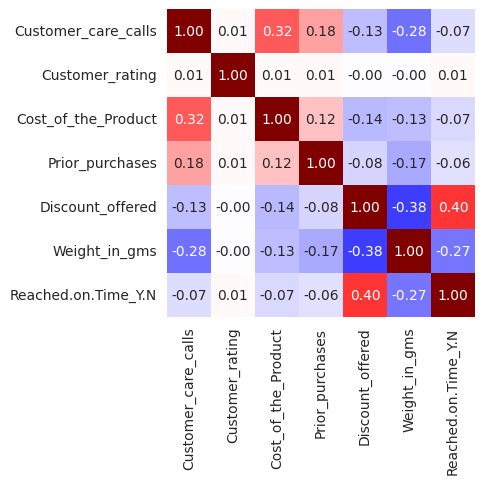

In [5]:
# Display the correlation heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(data[data.select_dtypes('number').columns].corr(),
            square=True, cmap='seismic', cbar=False, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.show()

The Cutomer Rating does not seem correlated at all with other features.

# Feature Vizualisation

Visualising the feature repartition.

## Categorical

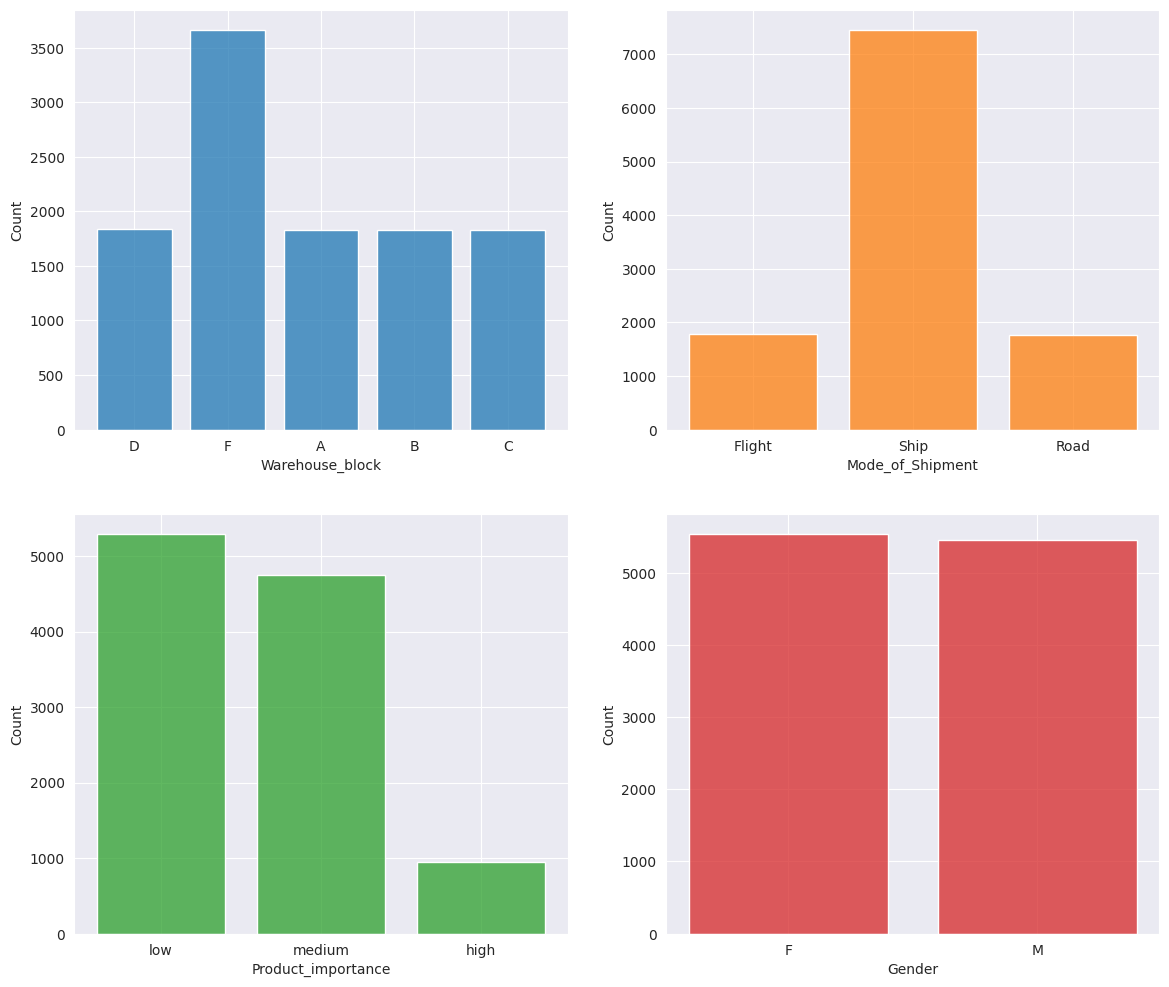

In [6]:
# Display class repartitions
plt.figure(figsize=(14, 12))

cat_features = data.select_dtypes('object').columns.values

for i, cat in enumerate(cat_features):

    plt.subplot(2, 2, i+1)
    sns.histplot(data[cat], shrink=0.8, color=pal[i])

plt.show()

- **Warehouse:** Blocks *A, B, C, D* are equilibrated while block *F* is predominent (1/2 ratio).
- **Shipment:** *Flight* and *Road* have similar observations while *Ship* is predominent (1/4 ratio).
- **Importance:** There is a majority of *low* and *medium* importances and a minority of *high* importances.
- **Genders:** Both classes are balanced.

## Numerical

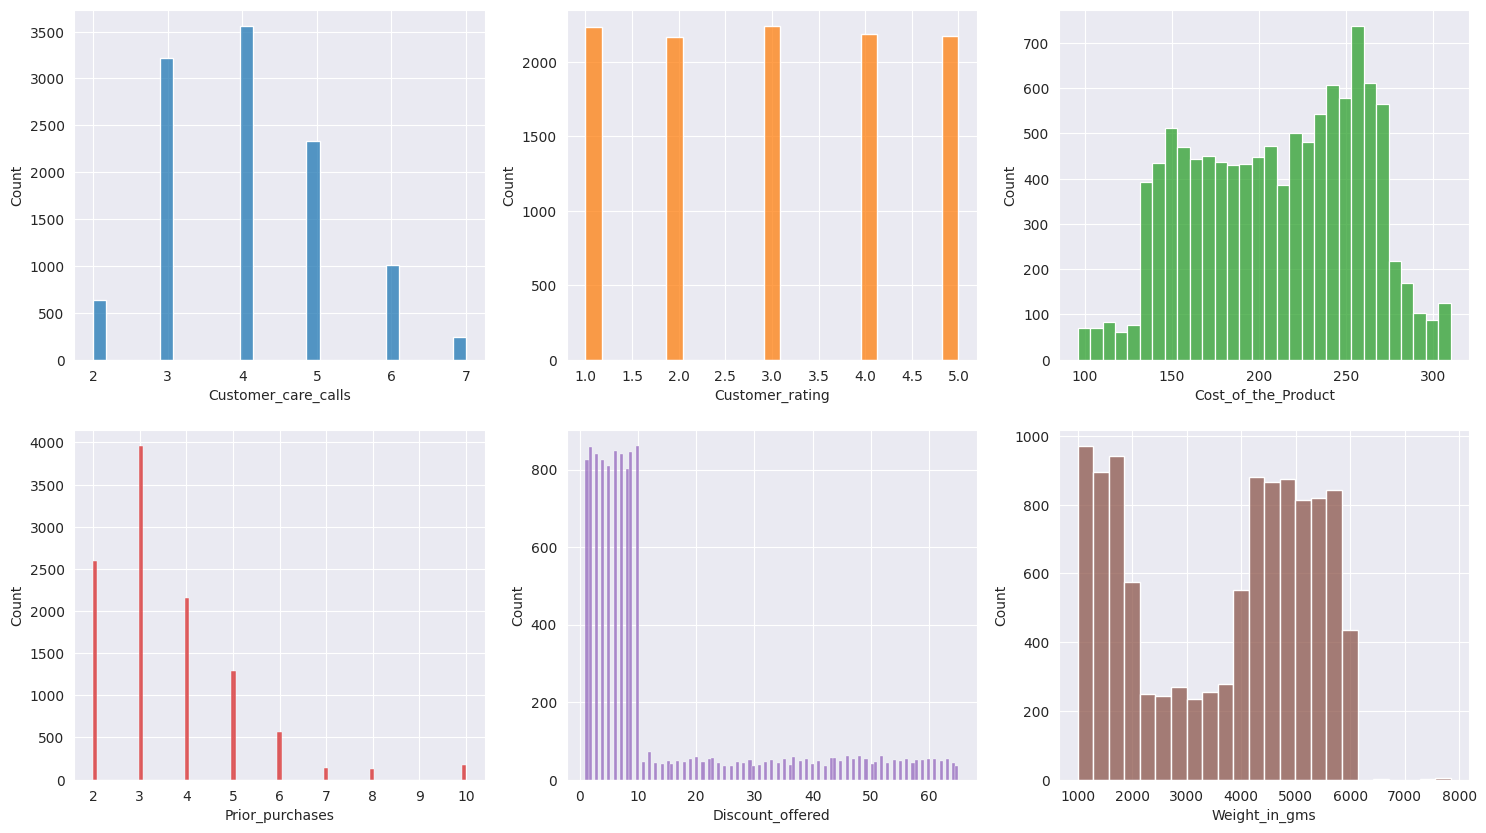

In [7]:
# Display value distributions
plt.figure(figsize=(18, 10))

num_features = data.select_dtypes('number').drop('Reached.on.Time_Y.N', axis=1).columns.values

for i, num in enumerate(num_features):

    plt.subplot(2, 3, i+1)
    sns.histplot(data[num], color=pal[i])

plt.show()

- **Care Calls:** Sligh positive skewed normal distribution with mode at 4.
- **Customer Rating:** Uniform distribution.
- **Costs:** 2 picks: smallest around 150, highest around 250.
- **Prior Purchases:** Positive skewed normal distribution, mode at 3.
- **Discount offered:** Separated into 2 uniform distributions: 0 to 10 is predominent and then small amount from 10 to 65.
- **Weight:** 3 zones: high from 1000 to 2000 and from 4000 to 6000. Low from 2000 to 4000.

# Target Analysis

In [8]:
# Ratio of delayed (1) and not delayed orders (0)
data['Reached.on.Time_Y.N'].value_counts() / data['Reached.on.Time_Y.N'].count()

1    0.596691
0    0.403309
Name: Reached.on.Time_Y.N, dtype: float64

The target classes are slightly unbalanced.

# Preprocessing

In [9]:
# def preprocess_inputs(df):
#     df = df.copy()

#     # One-hot encoding
#     df = pd.concat([df, pd.get_dummies(df['Warehouse_block'])], axis=1).drop('Warehouse_block', axis=1)
#     df = pd.concat([df, pd.get_dummies(df['Mode_of_Shipment'])], axis=1).drop('Mode_of_Shipment', axis=1)
#     df = pd.concat([df, pd.get_dummies(df['Product_importance'])], axis=1).drop('Product_importance', axis=1)
#     df = pd.concat([df, pd.get_dummies(df['Gender'], prefix='Sex')], axis=1).drop('Gender', axis=1)

#     # Split X and y
#     X = df.drop('Reached.on.Time_Y.N', axis=1)
#     y = df['Reached.on.Time_Y.N']

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=0)

#     # Scale X
#     scaler = StandardScaler()
#     X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
#     X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


#     return X_train, X_test, y_train, y_test

In [10]:
df = data.copy()

# One-hot encoding
df = pd.concat([df, pd.get_dummies(df['Warehouse_block'])], axis=1).drop('Warehouse_block', axis=1)
df = pd.concat([df, pd.get_dummies(df['Mode_of_Shipment'])], axis=1).drop('Mode_of_Shipment', axis=1)
df = pd.concat([df, pd.get_dummies(df['Product_importance'])], axis=1).drop('Product_importance', axis=1)
df = pd.concat([df, pd.get_dummies(df['Gender'], prefix='Sex')], axis=1).drop('Gender', axis=1)

# Split X and y
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=0)

# Scale X
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [11]:
# X_train, X_test, y_train, y_test = preprocess_inputs(data)

# Training

In [12]:
models = {
    "Logistic": LogisticRegression(),
    "   KNN  ": KNeighborsClassifier(),
    "   RF   ": RandomForestClassifier(max_depth=4, min_samples_leaf= 3,n_estimators= 200),
    "   DT   ": DecisionTreeClassifier(criterion= 'entropy', max_depth=4, min_samples_leaf= 5),
    "   SVC  ": SVC(probability=True),
}

print("-------- Training --------")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained!")
print("---------- Done ----------")

-------- Training --------
Logistic trained!
   KNN   trained!
   RF    trained!
   DT    trained!
   SVC   trained!
---------- Done ----------


# Results

In [13]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + "    Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))
    print("            F1 Score: {:.2f} %".format(f1_score(y_test, y_pred) * 100))
    print("              Recall: {:.2f} %".format(recall_score(y_test, y_pred) * 100))
    print("           Precision: {:.2f} %".format(precision_score(y_test, y_pred) * 100))
    print("-----------------------------")
    results.append(confusion_matrix(y_test, y_pred))

Logistic    Accuracy: 63.55 %
            F1 Score: 68.57 %
              Recall: 67.72 %
           Precision: 69.44 %
-----------------------------
   KNN      Accuracy: 62.09 %
            F1 Score: 67.14 %
              Recall: 65.94 %
           Precision: 68.38 %
-----------------------------
   RF       Accuracy: 66.86 %
            F1 Score: 68.97 %
              Recall: 62.69 %
           Precision: 76.63 %
-----------------------------
   DT       Accuracy: 67.82 %
            F1 Score: 64.81 %
              Recall: 50.46 %
           Precision: 90.56 %
-----------------------------
   SVC      Accuracy: 65.14 %
            F1 Score: 66.84 %
              Recall: 59.83 %
           Precision: 75.71 %
-----------------------------


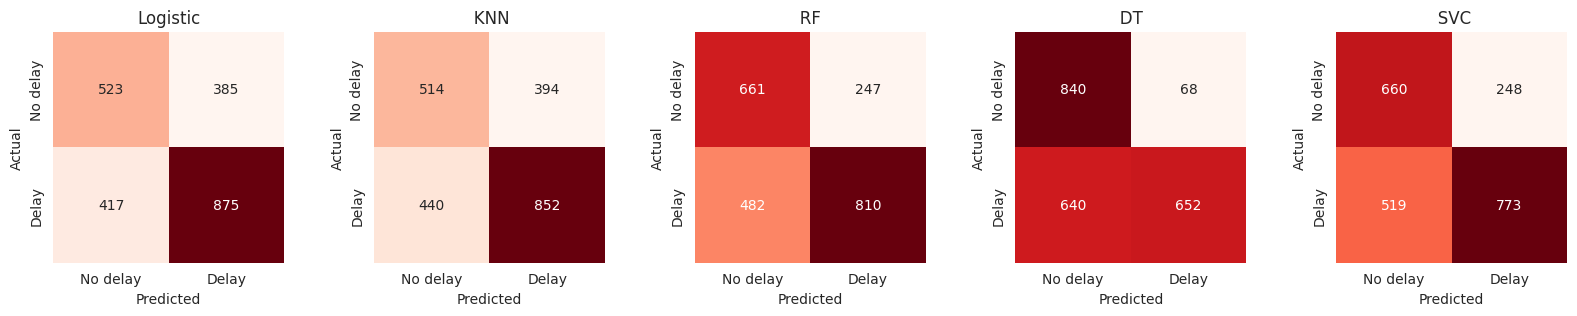

In [14]:
# Confusion matrices
plt.figure(figsize=(20, 3))

for i, name in enumerate(list(models.keys())):
    plt.subplot(1, 5, i + 1)
    sns.heatmap(results[i], annot=True, square=True, cbar=False,
                xticklabels=['No delay', 'Delay'], yticklabels=['No delay', 'Delay'], cmap='Reds', fmt='.0f')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.show()

Scores are low, it is not always possible to get high scores when features are not well correlated, and this is what we saw in the heatmap.

This dataset also seems to be fictive since some classes are perfectly balanced.

## Decision Tree Visualisation

[Text(0.5625, 0.9, 'Discount_offered <= -0.187\nentropy = 0.972\nsamples = 8799\nvalue = [3528, 5271]\nclass = Delayed'),
 Text(0.5, 0.7, 'Weight_in_gms <= 0.3\nentropy = 0.997\nsamples = 6653\nvalue = [3528, 3125]\nclass = On Time'),
 Text(0.25, 0.5, 'Prior_purchases <= -0.044\nentropy = 0.99\nsamples = 2190\nvalue = [968, 1222]\nclass = Delayed'),
 Text(0.125, 0.3, 'Weight_in_gms <= 0.222\nentropy = 0.758\nsamples = 525\nvalue = [115, 410]\nclass = Delayed'),
 Text(0.0625, 0.1, 'entropy = 0.413\nsamples = 325\nvalue = [27, 298]\nclass = Delayed'),
 Text(0.1875, 0.1, 'entropy = 0.99\nsamples = 200\nvalue = [88, 112]\nclass = Delayed'),
 Text(0.375, 0.3, 'Cost_of_the_Product <= 0.135\nentropy = 1.0\nsamples = 1665\nvalue = [853, 812]\nclass = On Time'),
 Text(0.3125, 0.1, 'entropy = 0.904\nsamples = 169\nvalue = [54, 115]\nclass = Delayed'),
 Text(0.4375, 0.1, 'entropy = 0.997\nsamples = 1496\nvalue = [799, 697]\nclass = On Time'),
 Text(0.75, 0.5, 'Weight_in_gms <= 1.434\nentropy = 0.

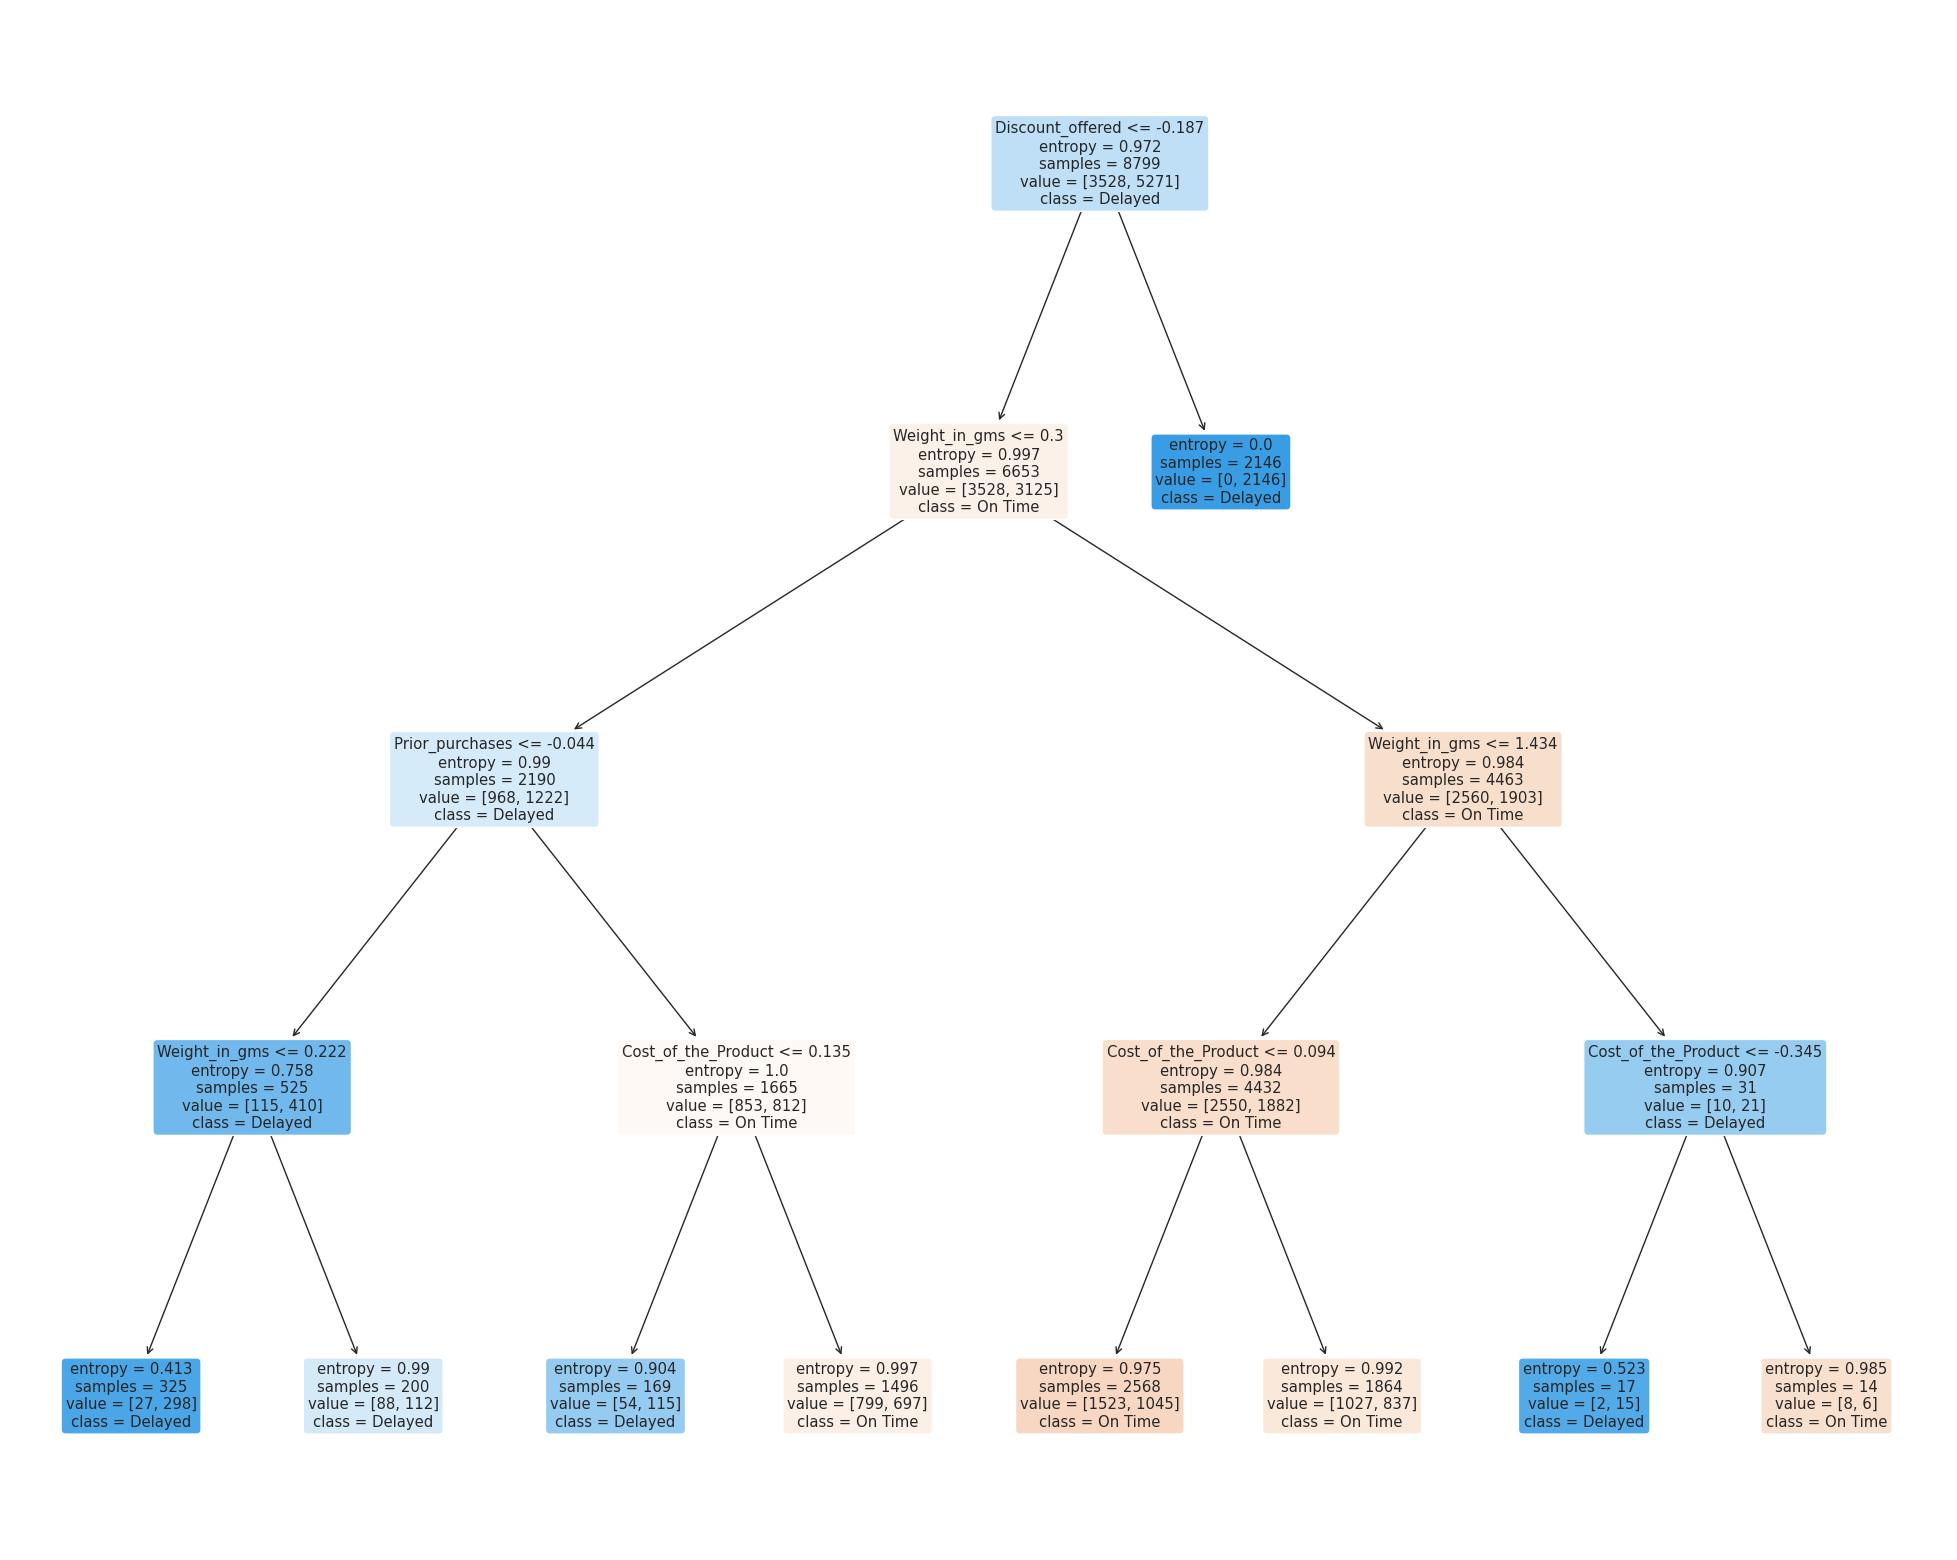

In [15]:
dt = models["   DT   "]
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt,feature_names=X_train.columns,class_names=['On Time','Delayed'],filled = True, rounded = True)

### Feature Importance

<Axes: >

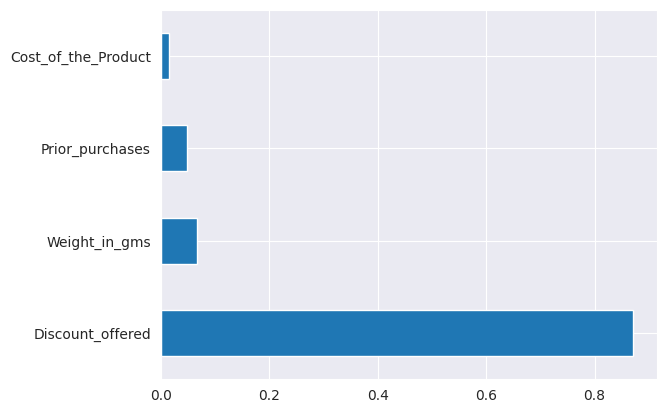

In [16]:
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

## Random Forest Visualisation

[Text(0.5, 0.9, 'low <= 0.029\ngini = 0.478\nsamples = 5539\nvalue = [3483, 5316]\nclass = Delayed'),
 Text(0.25, 0.7, 'Weight_in_gms <= 0.237\ngini = 0.475\nsamples = 2834\nvalue = [1750, 2755]\nclass = Delayed'),
 Text(0.125, 0.5, 'Cost_of_the_Product <= 0.135\ngini = 0.291\nsamples = 1243\nvalue = [350, 1633]\nclass = Delayed'),
 Text(0.0625, 0.3, 'Weight_in_gms <= 0.221\ngini = 0.042\nsamples = 585\nvalue = [21, 946]\nclass = Delayed'),
 Text(0.03125, 0.1, 'gini = 0.033\nsamples = 577\nvalue = [16, 939]\nclass = Delayed'),
 Text(0.09375, 0.1, 'gini = 0.486\nsamples = 8\nvalue = [5, 7]\nclass = Delayed'),
 Text(0.1875, 0.3, 'Weight_in_gms <= -0.997\ngini = 0.438\nsamples = 658\nvalue = [329, 687]\nclass = Delayed'),
 Text(0.15625, 0.1, 'gini = 0.488\nsamples = 369\nvalue = [328, 240]\nclass = On Time'),
 Text(0.21875, 0.1, 'gini = 0.004\nsamples = 289\nvalue = [1, 447]\nclass = Delayed'),
 Text(0.375, 0.5, 'Weight_in_gms <= 1.433\ngini = 0.494\nsamples = 1591\nvalue = [1400, 1122]\n

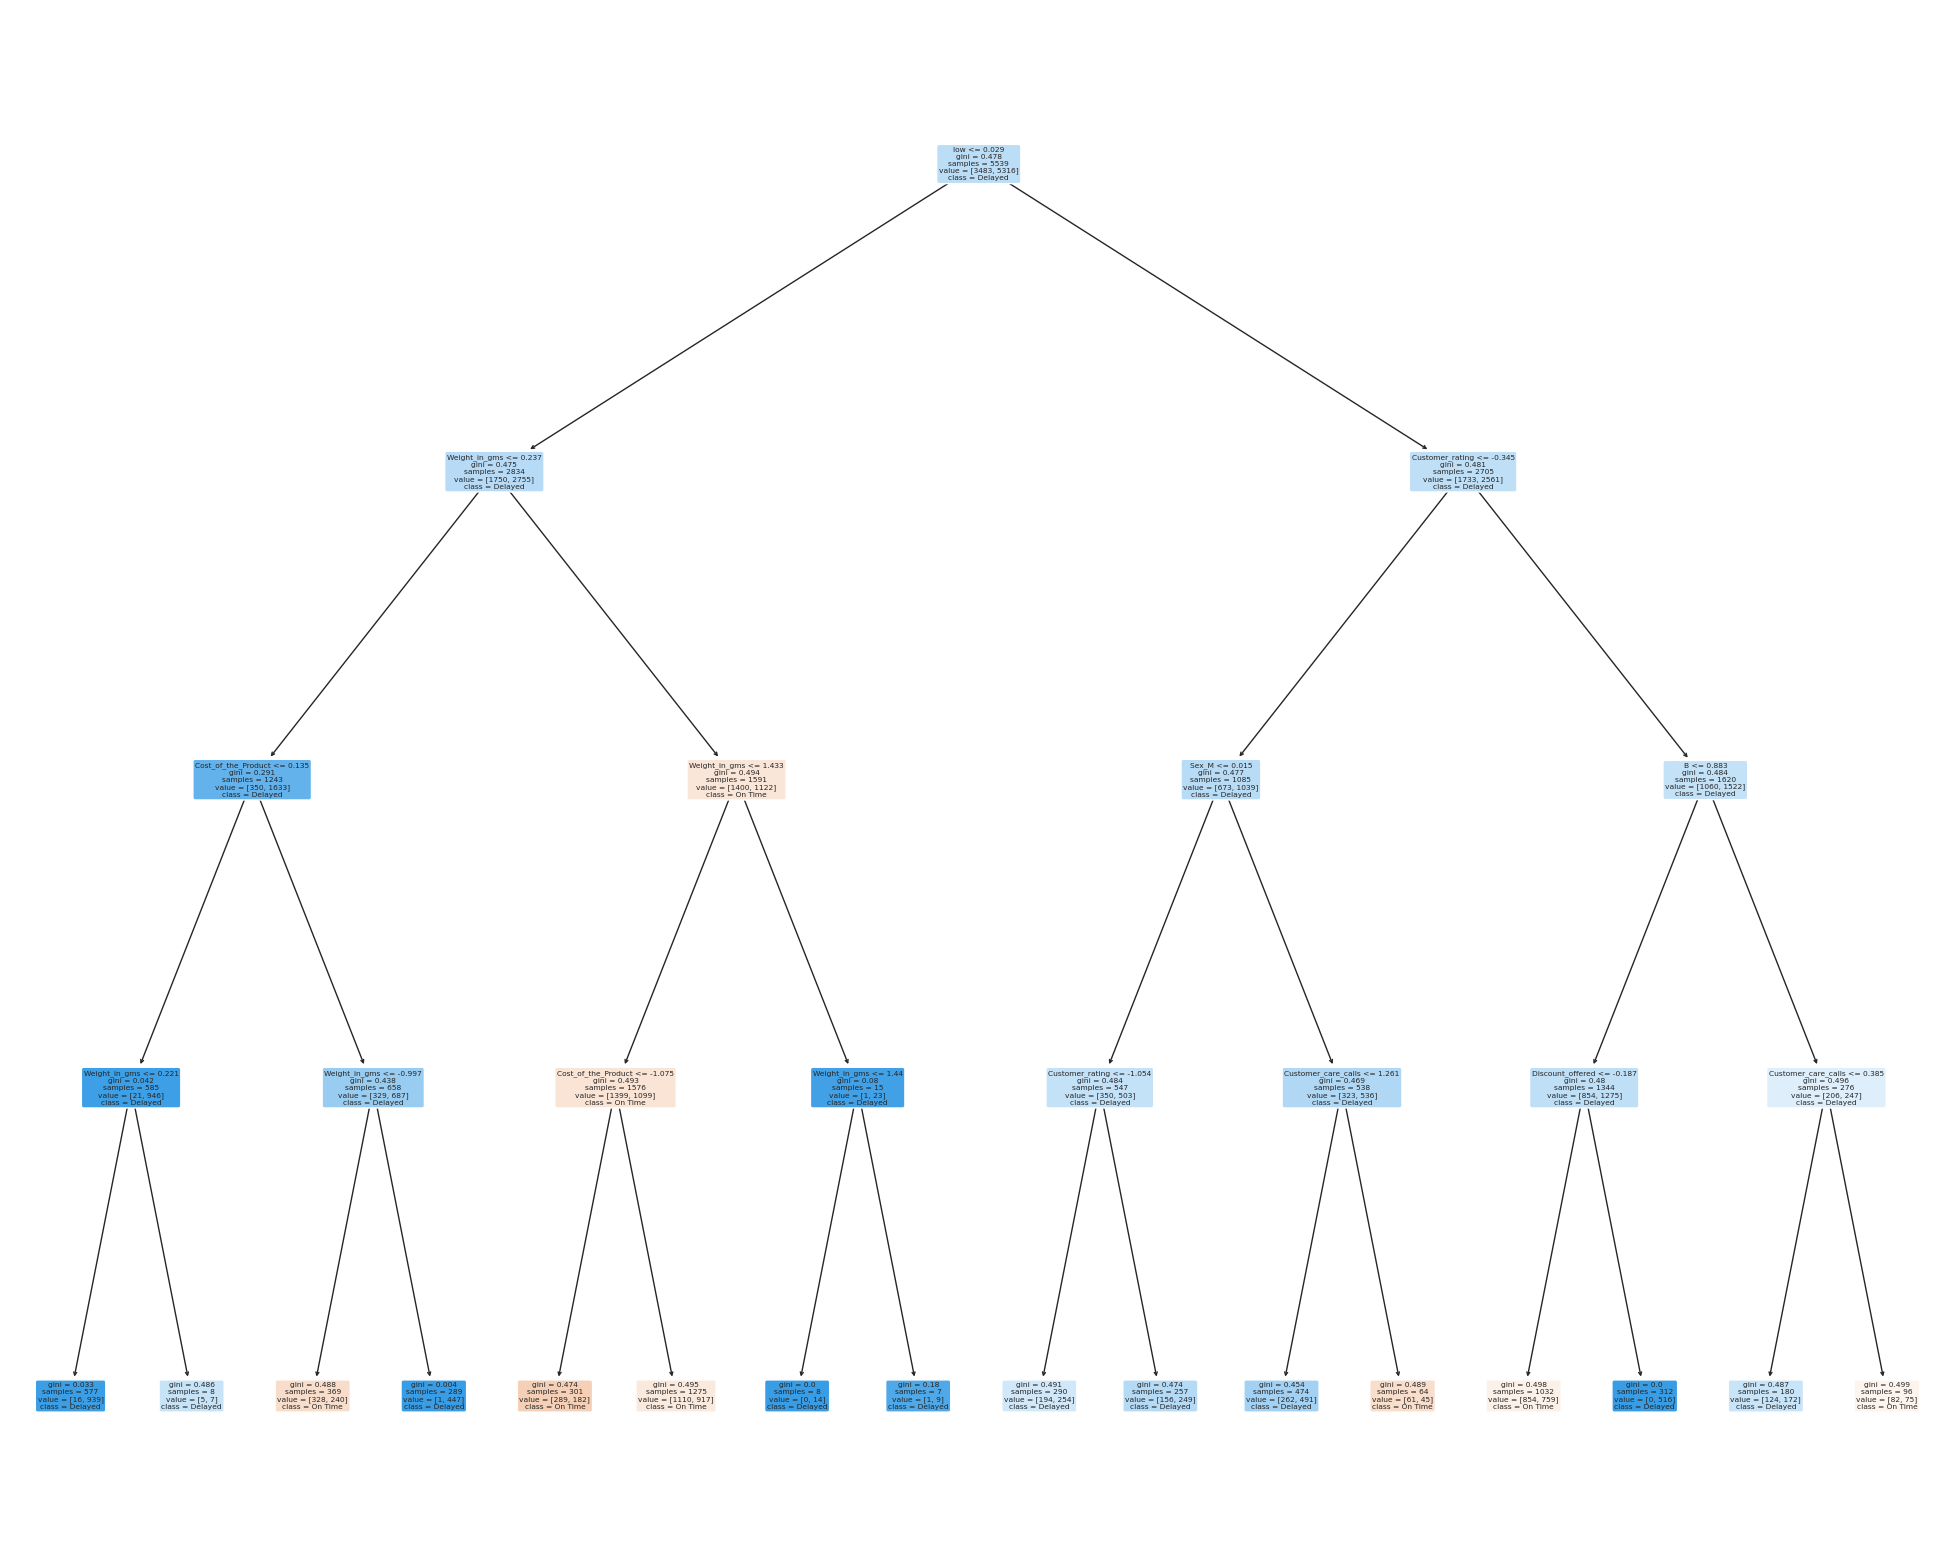

In [17]:
rf = models["   RF   "]
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rf.estimators_[1],feature_names=X_train.columns,class_names=['On Time','Delayed'],filled = True, rounded = True)

### Feature Importance

<Axes: >

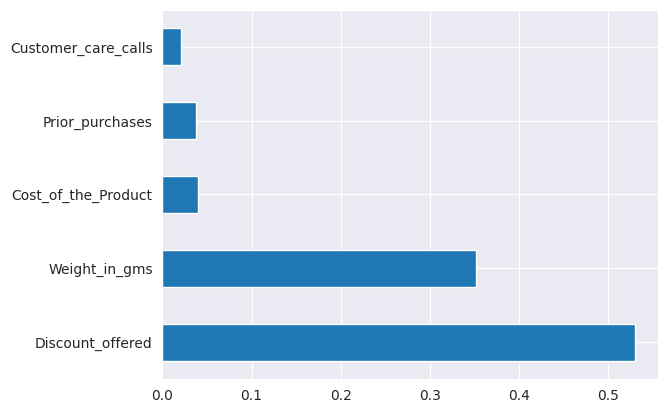

In [18]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')